# Import Dependencies and Set Variables

In [1]:
import pickle
import re
import cv2
import umap
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from PIL.ExifTags import TAGS
import os 

/opt/anaconda3/envs/Nat_SPNandNoisePrint/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_files_to_ignore = ['NatOld_20180409_154622.jpg', 'NatOld2_20170421_123311.jpg','AdamOld_20191015_155330.jpg']

# Load Noiseprints
1. Load noiseprints
2. Remove iCloudPhotos and iCloudPhotos2 as these are present in 'converted'
3. Remove files to ignore (these are using panaramic modes on phones)

In [3]:
with open('image_noise_prints.pickle', 'rb') as handle:
    output_dict = pickle.load(handle)

In [4]:
len(output_dict)

294

In [5]:
output_dict = {k:v for k,v in output_dict.items() if not 'iCloudPhotos_' in k}
output_dict = {k:v for k,v in output_dict.items() if not 'iCloudPhotos2_' in k}
len(output_dict)

247

In [6]:
output_dict = {k:v for k,v in output_dict.items() if k not in image_files_to_ignore}
len(output_dict)

244

# Get Image Metadata

In [7]:
from utils.image_processing import get_metadata_for_images_in_path_list

In [8]:
path_list= [
    '../Nat_Old/', 
    '../Nat_Old_2/', 
    '../Nat_New/', 
    '../Nat_New_2/',
    '../iCloud_Photos_Converted/', 
    '../Adam_Old_Old_2/', 
    '../Adam_Old_Old/', 
    '../Adam_Old_2/', 
    '../Adam_Old/']

In [9]:
meta_data_dict = get_metadata_for_images_in_path_list(path_list)

100%|██████████| 41/41 [00:00<00:00, 910.68it/s]


In [10]:
metadata_df = pd.DataFrame(data=meta_data_dict).transpose()
metadata_df.reset_index(inplace=True)
metadata_df.head()

,index,Filename,Image Size,Image Height,Image Width,Image Format,Image Mode,Image is Animated,Frames in Image,ResolutionUnit,...,DateTime,YCbCrPositioning,XResolution,YResolution,ImageWidth,ImageLength,GPSInfo,HostComputer,TileWidth,TileLength
0,NatOld_20180410_103810.jpg,../Nat_Old/20180410_103810.jpg,"(4032, 2268)",2268,4032,JPEG,RGB,False,1,2,...,2018:04:10 10:38:09,1,72.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NatOld_20180409_154622.jpg,../Nat_Old/20180409_154622.jpg,"(9712, 3776)",3776,9712,JPEG,RGB,False,1,2,...,2018:04:09 15:46:22,1,72.0,72.0,0,0,NaN,NaN,NaN,NaN
2,NatOld_20180409_132214.jpg,../Nat_Old/20180409_132214.jpg,"(4032, 3024)",3024,4032,JPEG,RGB,False,1,2,...,2018:04:09 13:22:14,1,72.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NatOld_20180409_131447.jpg,../Nat_Old/20180409_131447.jpg,"(3264, 2448)",2448,3264,JPEG,RGB,False,1,2,...,2018:04:09 13:14:47,1,72.0,72.0,3264,2448,NaN,NaN,NaN,NaN
4,NatOld_20180409_022438.jpg,../Nat_Old/20180409_022438.jpg,"(4032, 3024)",3024,4032,JPEG,RGB,False,1,2,...,2018:04:09 02:24:38,1,72.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
int_columns = ['Image Height', 'Image Width', 'YCbCrPositioning', 'XResolution', 'YResolution', 'ImageWidth', 'ImageLength', 'GPSInfo', 'TileWidth', 'TileLength']
date_time_columns = ['DateTime'] # Not currently used, so not currently updated as there are issues with some of the dates to resolve.

In [12]:
metadata_df[int_columns] = metadata_df[int_columns].apply(pd.to_numeric, errors='coerce')

In [13]:
metadata_df.to_csv('metadata_df.csv')

# Get Aspect Ratio

In [14]:
from utils.general_utils import split_column_of_tuples
from utils.image_processing import get_shape, get_aspect_ratio

In [15]:
output_dict = get_shape(output_dict=output_dict, key_for_shape='noiseprint')

df = pd.DataFrame(data=output_dict).transpose()
df = split_column_of_tuples(df=df, column_to_split='shape', list_of_new_column_names=['width', 'height'])
df = get_aspect_ratio(df=df, columns_list=['width', 'height'])

df.head()


100%|██████████| 244/244 [00:00<00:00, 543499.83it/s]


,noiseprint,QF,time,shape,width,height,max,min,aspect_ratio
NatOld_20180410_103810.jpg,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...",98.0,180.681697,"(2268, 4032)",2268,4032,4032,2268,0.5625
NatOld_20180409_132214.jpg,"[[-0.8514008, 0.26750848, 0.13929462, -0.69182...",98.0,238.81108,"(3024, 4032)",3024,4032,4032,3024,0.7500
NatOld_20180409_131447.jpg,"[[-0.8919279, -0.026079278, -0.08797012, -0.03...",98.0,160.965038,"(2448, 3264)",2448,3264,3264,2448,0.7500
NatOld_20180409_022438.jpg,"[[-0.7459606, -0.3861774, -0.09068421, -0.0726...",96.0,238.889262,"(3024, 4032)",3024,4032,4032,3024,0.7500
NatOld_20180410_100312.jpg,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...",98.0,183.387985,"(2268, 4032)",2268,4032,4032,2268,0.5625


# Rotating Images

In [16]:
from utils.image_processing import rotate_images

In [17]:
df = rotate_images(df=df, image_column='noiseprint', dimensions_list=['width', 'height'])
df.head()

,noiseprint,QF,time,shape,width,height,max,min,aspect_ratio,requires_rotate,noiseprint_rotated
NatOld_20180410_103810.jpg,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...",98.0,180.681697,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593..."
NatOld_20180409_132214.jpg,"[[-0.8514008, 0.26750848, 0.13929462, -0.69182...",98.0,238.81108,"(3024, 4032)",3024,4032,4032,3024,0.7500,False,"[[-0.8514008, 0.26750848, 0.13929462, -0.69182..."
NatOld_20180409_131447.jpg,"[[-0.8919279, -0.026079278, -0.08797012, -0.03...",98.0,160.965038,"(2448, 3264)",2448,3264,3264,2448,0.7500,False,"[[-0.8919279, -0.026079278, -0.08797012, -0.03..."
NatOld_20180409_022438.jpg,"[[-0.7459606, -0.3861774, -0.09068421, -0.0726...",96.0,238.889262,"(3024, 4032)",3024,4032,4032,3024,0.7500,False,"[[-0.7459606, -0.3861774, -0.09068421, -0.0726..."
NatOld_20180410_100312.jpg,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...",98.0,183.387985,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8488726, -0.052164916, -0.25681588, -0.03..."


# Resizing, Flattening and UMAP

In [18]:
from utils.image_processing import resize_images

In [19]:
reducer = umap.UMAP()

## All to largest size

In [20]:
df_all_to_largest = resize_images(df=df, image_column='noiseprint_rotated', how='max')
df_all_to_largest.head()

,noiseprint,QF,time,shape,width,height,max,min,aspect_ratio,requires_rotate,noiseprint_rotated,noiseprint_rotated_resized
NatOld_20180410_103810.jpg,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...",98.0,180.681697,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...","[-1.2105765, -0.11679175, 0.30824825, -0.14709..."
NatOld_20180409_132214.jpg,"[[-0.8514008, 0.26750848, 0.13929462, -0.69182...",98.0,238.81108,"(3024, 4032)",3024,4032,4032,3024,0.7500,False,"[[-0.8514008, 0.26750848, 0.13929462, -0.69182...","[-0.9052162, -0.14564642, 0.47248906, -0.03315..."
NatOld_20180409_131447.jpg,"[[-0.8919279, -0.026079278, -0.08797012, -0.03...",98.0,160.965038,"(2448, 3264)",2448,3264,3264,2448,0.7500,False,"[[-0.8919279, -0.026079278, -0.08797012, -0.03...","[-1.2221814, -0.6511146, 0.018376105, 0.050711..."
NatOld_20180409_022438.jpg,"[[-0.7459606, -0.3861774, -0.09068421, -0.0726...",96.0,238.889262,"(3024, 4032)",3024,4032,4032,3024,0.7500,False,"[[-0.7459606, -0.3861774, -0.09068421, -0.0726...","[-0.74480516, -0.5423153, -0.2205386, -0.07863..."
NatOld_20180410_100312.jpg,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...",98.0,183.387985,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...","[-1.2053318, -0.35440543, 0.022387119, -0.3591..."


In [ ]:
######## HERE ##########
#### Determine best approach for running umap on resized noiseprint ####
df_test = pd.DataFrame(df_all_to_largest['noiseprint_rotated_resized'].values.tolist())
df_test

In [ ]:
df_test = pd.DataFrame(df_all_to_largest['noiseprint_rotated_resized']).todict()

In [41]:
df_all_to_largest[['umap0', 'umap1']] = reducer.fit_transform(df_all_to_largest['noiseprint_rotated_resized'])
df_all_to_largest.head()

ValueError: setting an array element with a sequence.

## All to smallest size

In [13]:
df_all_to_smallest = resize_images(df=df, image_column='noiseprint_rotated', how='min')
df_all_to_smallest.head()

,noiseprint,QF,time,shape,width,height,max,min,aspect_ratio,requires_rotate,noiseprint_rotated,noiseprint_rotated_resized
NatOld_20180410_103810.jpg,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...",98.0,180.681697,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...","[-0.39910325, -0.3497472, -0.38865238, -0.0229..."
NatOld_20180409_132214.jpg,"[[-0.8514008, 0.26750848, 0.13929462, -0.69182...",98.0,238.81108,"(3024, 4032)",3024,4032,4032,3024,0.7500,False,"[[-0.8514008, 0.26750848, 0.13929462, -0.69182...","[-0.43962646, -0.19801019, -0.26951414, -0.062..."
NatOld_20180409_131447.jpg,"[[-0.8919279, -0.026079278, -0.08797012, -0.03...",98.0,160.965038,"(2448, 3264)",2448,3264,3264,2448,0.7500,False,"[[-0.8919279, -0.026079278, -0.08797012, -0.03...","[-0.38642395, -0.5849928, -0.6875089, -0.93239..."
NatOld_20180409_022438.jpg,"[[-0.7459606, -0.3861774, -0.09068421, -0.0726...",96.0,238.889262,"(3024, 4032)",3024,4032,4032,3024,0.7500,False,"[[-0.7459606, -0.3861774, -0.09068421, -0.0726...","[-0.4643437, -0.48550227, -0.38342187, -0.6458..."
NatOld_20180410_100312.jpg,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...",98.0,183.387985,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...","[-0.46343023, -0.21154174, -0.22713476, -0.355..."


## To largest, considering aspect ratio

In [14]:
df_ar_to_largest = resize_images(df=df, image_column='noiseprint_rotated', how='max', respect_aspect_ratio=True)
df_ar_to_largest.head()

/Users/adam/Desktop/Nat_SPNandNoiseprint/noiseprint_main/utils/image_processing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = df.apply(lambda row: cv2.resize(row[image_column], dsize = new_size, interpolation=cv2.INTER_LANCZOS4).flatten(), axis=1)


,noiseprint,QF,time,shape,width,height,max,min,aspect_ratio,requires_rotate,noiseprint_rotated,noiseprint_rotated_resized
NatOld_20180410_103810.jpg,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...",98.0,180.681697,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...","[-1.2105765, -0.11679175, 0.30824825, -0.14709..."
NatOld_20180410_100312.jpg,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...",98.0,183.387985,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...","[-1.2053318, -0.35440543, 0.022387119, -0.3591..."
NatOld_20180410_102707.jpg,"[[-0.83693403, 0.2376078, 0.10154625, -0.19527...",98.0,183.676415,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.83693403, 0.2376078, 0.10154625, -0.19527...","[-1.2114552, -0.21708064, 0.43059593, -0.06422..."
NatOld_20180410_133813.jpg,"[[-0.943974, -0.13753621, 0.3383838, 0.3796807...",98.0,183.556867,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.943974, -0.13753621, 0.3383838, 0.3796807...","[-1.28687, -0.5514062, 0.14764751, 0.34983245,..."
NatOld_20180410_142549.jpg,"[[-0.84985816, -0.16805258, 0.10081705, 0.3396...",98.0,180.90556,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.84985816, -0.16805258, 0.10081705, 0.3396...","[-1.1600351, -0.47252297, -0.013737379, 0.0855..."


## To smallest, considering aspect ratio

In [15]:
df_ar_to_smallest = resize_images(df=df, image_column='noiseprint_rotated', how='max', respect_aspect_ratio=True)
df_ar_to_smallest.head()

/Users/adam/Desktop/Nat_SPNandNoiseprint/noiseprint_main/utils/image_processing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = df.apply(lambda row: cv2.resize(row[image_column], dsize = new_size, interpolation=cv2.INTER_LANCZOS4).flatten(), axis=1)


,noiseprint,QF,time,shape,width,height,max,min,aspect_ratio,requires_rotate,noiseprint_rotated,noiseprint_rotated_resized
NatOld_20180410_103810.jpg,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...",98.0,180.681697,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8299054, 0.25258455, -0.08180045, 0.25593...","[-1.2105765, -0.11679175, 0.30824825, -0.14709..."
NatOld_20180410_100312.jpg,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...",98.0,183.387985,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.8488726, -0.052164916, -0.25681588, -0.03...","[-1.2053318, -0.35440543, 0.022387119, -0.3591..."
NatOld_20180410_102707.jpg,"[[-0.83693403, 0.2376078, 0.10154625, -0.19527...",98.0,183.676415,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.83693403, 0.2376078, 0.10154625, -0.19527...","[-1.2114552, -0.21708064, 0.43059593, -0.06422..."
NatOld_20180410_133813.jpg,"[[-0.943974, -0.13753621, 0.3383838, 0.3796807...",98.0,183.556867,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.943974, -0.13753621, 0.3383838, 0.3796807...","[-1.28687, -0.5514062, 0.14764751, 0.34983245,..."
NatOld_20180410_142549.jpg,"[[-0.84985816, -0.16805258, 0.10081705, 0.3396...",98.0,180.90556,"(2268, 4032)",2268,4032,4032,2268,0.5625,False,"[[-0.84985816, -0.16805258, 0.10081705, 0.3396...","[-1.1600351, -0.47252297, -0.013737379, 0.0855..."


# Flattened Noiseprints

## All

In [2]:
with open('tmp_output_dict_all.pickle', 'rb') as handle:
    output_dict = pickle.load(handle)

In [3]:
data_all = []
keys_all = []

for key in tqdm(list(output_dict.keys())):
    data_all.append(output_dict[key]['resized_noiseprint_all'].flatten())
    keys_all.append(key)

100%|██████████| 244/244 [00:56<00:00,  4.29it/s]


In [ ]:
with open('tmp_data_all.pickle', 'wb') as handle:
    pickle.dump(data_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open('tmp_keys_all.pickle', 'wb') as handle:
    pickle.dump(keys_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Smaller Aspect Ratio

In [5]:
with open('tmp_output_dict_small.pickle', 'rb') as handle:
    small_output_dict = pickle.load(handle)

In [6]:
data_small = []
keys_small = []

for key in tqdm(list(small_output_dict.keys())):
    data_small.append(small_output_dict[key]['resized_noiseprint_small'].flatten())
    keys_small.append(key)

100%|██████████| 94/94 [00:10<00:00,  8.77it/s]


In [32]:
with open('tmp_data_small.pickle', 'wb') as handle:
    pickle.dump(data_small, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('tmp_keys_small.pickle', 'wb') as handle:
    pickle.dump(keys_small, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Larger Aspect Ratio

In [2]:
with open('tmp_output_dict_large.pickle', 'rb') as handle:
    large_output_dict = pickle.load(handle)

In [3]:
data_large = []
keys_large = []

for key in tqdm(list(large_output_dict.keys())):
    data_large.append(large_output_dict[key]['resized_noiseprint_large'].flatten())
    keys_large.append(key)

100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


In [34]:
with open('tmp_data_large.pickle', 'wb') as handle:
    pickle.dump(data_large, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open('tmp_keys_large.pickle', 'wb') as handle:
    pickle.dump(keys_large, handle, protocol=pickle.HIGHEST_PROTOCOL)

# UMAP

## All

In [19]:
with open('tmp_data_all.pickle', 'rb') as handle:
    data_all = pickle.load(handle)

In [3]:
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(data_all)
embedding_all.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/Nat_SPNandNoisePrint/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


(244, 2)

In [5]:
with open('np_umap_all.pickle', 'wb') as handle:
    pickle.dump(embedding_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
umap_df_all = pd.DataFrame({'key': keys_all, 'umap_0': embedding_all[:, 0], 'umap_1': embedding_all[:, 1]})
umap_df

## Smaller Aspect Ratio

In [6]:
with open('tmp_data_small.pickle', 'rb') as handle:
    data_small = pickle.load(handle)

In [7]:
reducer = umap.UMAP()
embedding_small = reducer.fit_transform(data_small)
embedding_small.shape

(94, 2)

In [8]:
with open('np_umap_small.pickle', 'wb') as handle:
    pickle.dump(embedding_small, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Larger Aspect Ratio

In [9]:
with open('tmp_data_large.pickle', 'rb') as handle:
    data_large = pickle.load(handle)

In [10]:
reducer = umap.UMAP()
embedding_large = reducer.fit_transform(data_large)
embedding_large.shape

(125, 2)

In [11]:
with open('np_umap_large.pickle', 'wb') as handle:
    pickle.dump(embedding_large, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Combining Outputs

## All

In [86]:
with open('tmp_keys_all.pickle', 'rb') as handle:
    keys_all = pickle.load(handle)

In [87]:
with open('np_umap_all.pickle', 'rb') as handle:
    umap_all = pickle.load(handle)

In [88]:
umap_df_all = pd.DataFrame({'key': keys_all, 'umap_all_0': umap_all[:, 0], 'umap_all_1': umap_all[:,1]})
umap_df_all.head()

,key,umap_all_0,umap_all_1
0,NatOld_20180410_103810.jpg,-8.388719,-0.395307
1,NatOld_20180409_132214.jpg,18.407988,10.155152
2,NatOld_20180409_131447.jpg,14.080409,8.055107
3,NatOld_20180409_022438.jpg,19.931227,11.111171
4,NatOld_20180410_100312.jpg,-8.499428,-0.287890


In [89]:
umap_df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         244 non-null    object 
 1   umap_all_0  244 non-null    float32
 2   umap_all_1  244 non-null    float32
dtypes: float32(2), object(1)
memory usage: 3.9+ KB


In [90]:
umap_df_all.to_csv('umap_df_all.csv')

## Smaller Aspect Ratio

In [91]:
with open('tmp_keys_small.pickle', 'rb') as handle:
    keys_small = pickle.load(handle)

In [92]:
with open('np_umap_small.pickle', 'rb') as handle:
    umap_small = pickle.load(handle)

In [93]:
umap_df_small = pd.DataFrame({'key': keys_small, 'umap_small_0': umap_small[:, 0], 'umap_small_1': umap_small[:,1]})
umap_df_small.head()

,key,umap_small_0,umap_small_1
0,NatOld_20180410_103810.jpg,10.774058,1.086212
1,NatOld_20180410_100312.jpg,10.449657,0.846257
2,NatOld_20180410_102707.jpg,10.659710,0.850699
3,NatOld_20180410_133813.jpg,10.820896,1.046218
4,NatOld_20180410_142549.jpg,10.549643,1.059773


In [94]:
umap_df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           94 non-null     object 
 1   umap_small_0  94 non-null     float32
 2   umap_small_1  94 non-null     float32
dtypes: float32(2), object(1)
memory usage: 1.6+ KB


In [95]:
umap_df_small.to_csv('umap_df_small.csv')

## Larger Aspect Ratio

In [15]:
with open('tmp_keys_large.pickle', 'rb') as handle:
    keys_large = pickle.load(handle)

In [16]:
with open('np_umap_large.pickle', 'rb') as handle:
    umap_large = pickle.load(handle)

In [17]:
umap_df_large = pd.DataFrame({'key': keys_large, 'umap_large_0': umap_large[:, 0], 'umap_large_1': umap_large[:,1]})
umap_df_large.head()

,key,umap_large_0,umap_large_1
0,NatOld_20180409_132214.jpg,-5.283096,9.121709
1,NatOld_20180409_131447.jpg,-4.246466,8.756784
2,NatOld_20180409_022438.jpg,-4.556537,7.735430
3,NatOld_20180408_193248.jpg,-3.601152,7.896025
4,NatOld_20180409_124115.jpg,-6.022322,9.880553


In [18]:
umap_df_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           125 non-null    object 
 1   umap_large_0  125 non-null    float32
 2   umap_large_1  125 non-null    float32
dtypes: float32(2), object(1)
memory usage: 2.1+ KB


In [19]:
umap_df_large.to_csv('umap_df_large.csv')

## Combining UMAP outputs with Metadata

In [98]:
umap_df_all = pd.read_csv('umap_df_all.csv', index_col='key')
umap_df_small = pd.read_csv('umap_df_small.csv', index_col='key')
umap_df_large = pd.read_csv('umap_df_large.csv', index_col='key')

metadata_df = pd.read_csv('metadata_df.csv', index_col='index')
shapes_df = pd.read_csv('shapes_df.csv', index_col='key')

In [100]:
metadata_df.drop('Unnamed: 0', axis=1, inplace=True)
umap_df_all.drop('Unnamed: 0', axis=1, inplace=True)
umap_df_small.drop('Unnamed: 0', axis=1, inplace=True)
umap_df_large.drop('Unnamed: 0', axis=1, inplace=True)
shapes_df.drop('Unnamed: 0', axis=1, inplace=True)

In [101]:
umap_meta_df = metadata_df.merge(umap_df_all, left_index=True, right_index=True)
umap_meta_df = umap_meta_df.merge(umap_df_small,left_index=True, right_index=True, how='outer')
umap_meta_df = umap_meta_df.merge(umap_df_large, left_index=True, right_index=True, how='outer')
umap_meta_df = umap_meta_df.merge(shapes_df, left_index=True, right_index=True, how='outer')

In [102]:
umap_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, AdamOld2_20191019_130201.jpg to iCloudPhotosConverted_IMG_0808.JPG
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Filename           244 non-null    object 
 1   Image Size         244 non-null    object 
 2   Image Height       244 non-null    int64  
 3   Image Width        244 non-null    int64  
 4   Image Format       244 non-null    object 
 5   Image Mode         244 non-null    object 
 6   Image is Animated  244 non-null    bool   
 7   Frames in Image    244 non-null    int64  
 8   ResolutionUnit     219 non-null    float64
 9   ExifOffset         219 non-null    float64
 10  Make               212 non-null    object 
 11  Model              212 non-null    object 
 12  Software           212 non-null    object 
 13  Orientation        219 non-null    float64
 14  DateTime           212 non-null    object 
 15  YCbCrPositioning   18

In [103]:
umap_meta_df.to_csv('umap_meta_df.csv')

# Trash 

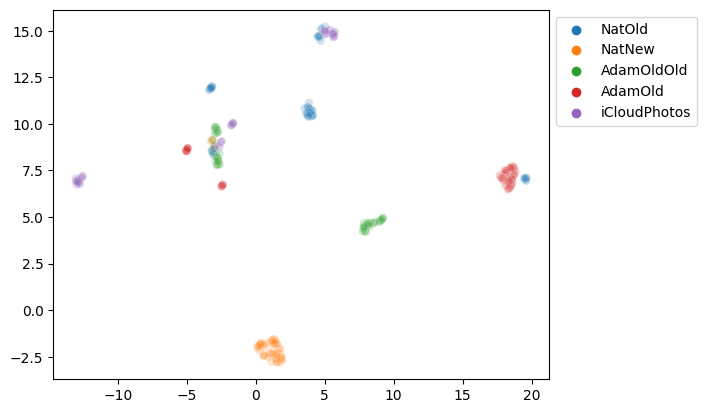

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns


ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue = camera_id_reduced, alpha=0.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Adam Old == SamsungS10
# Adam

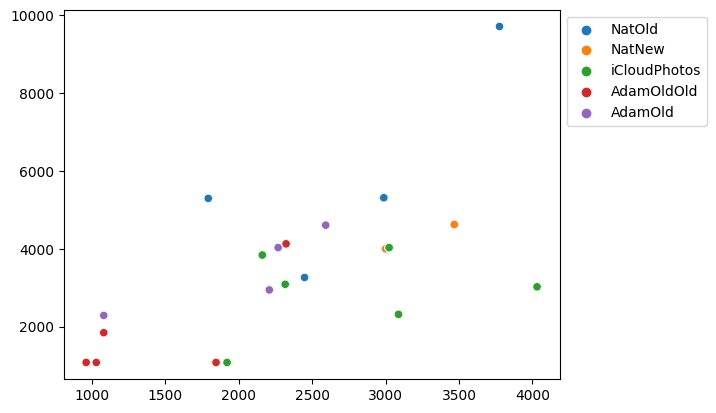

In [41]:
ax = sns.scatterplot(x=shapes_x, y=shapes_y, hue = camera_id_reduced)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.scatter(

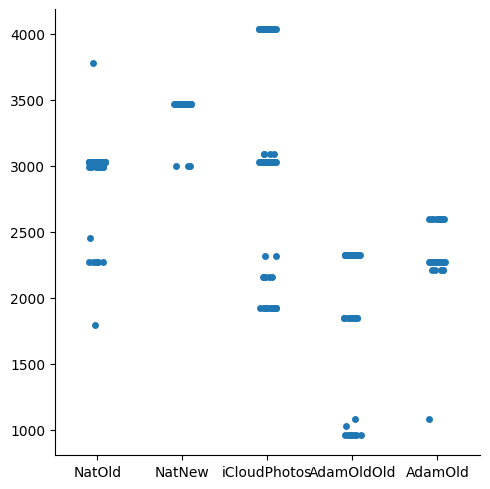

In [42]:
sns.catplot(x=camera_id_reduced, y = shapes_x)

In [77]:
software = []
for key in meta_data_dict.keys():
    try:
        software.append(meta_data_dict[key]['Software'])
    except:
        software.append('None')
    # sw = meta_data_dict[key]['Software']
    # software.append(sw)

In [78]:
set(software)

{'15.6.1',
 '16.0.2',
 '16.1.1',
 'A536BXXU2AVF2',
 'A536BXXU3AVGA',
 'G920FXXU4DPJK',
 'G950FXXU1CRB7',
 'G973FXXS3ASH1',
 'G973FXXU3ASIG',
 'N9005XXUGBOK6',
 'None'}

In [80]:
len(software)

247

In [125]:
phone_code = [sw[:4] for sw in software]
set(phone_code)

{'15.6', '16.0', '16.1', 'A536', 'G920', 'G950', 'G973', 'N900', 'None'}

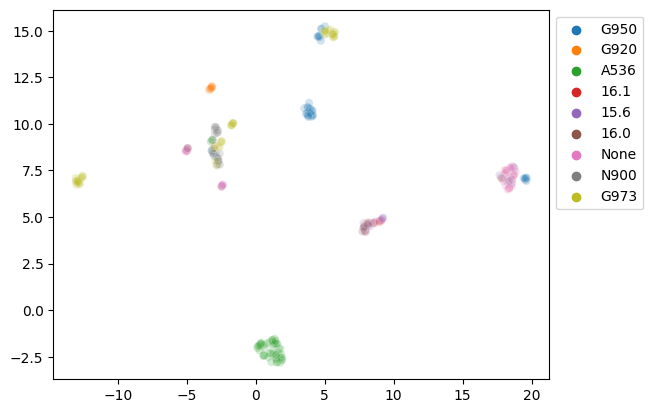

In [126]:
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue = phone_code, alpha=0.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [ ]:
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue = phone_code, alpha=0.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [133]:
umap_df.set_index('key', inplace=True)

,camera_id,umap_0,umap_1
key,,,
NatOld_20180410_103810.jpg,NatOld,19.537642,7.010220
NatOld_20180409_154622.jpg,NatOld,-2.914402,8.417629
NatOld_20180409_132214.jpg,NatOld,3.519368,10.839135
NatOld_20180409_131447.jpg,NatOld,-3.016541,8.284275
NatOld_20180409_022438.jpg,NatOld,4.553221,14.702798
...,...,...,...
iCloudPhotosConverted_IMG_0742.JPG,iCloudPhotosConverted,-12.644845,7.101682
iCloudPhotosConverted_IMG_0622.JPG,iCloudPhotosConverted,-1.786924,9.930901
iCloudPhotosConverted_IMG_0804.JPG,iCloudPhotosConverted,5.682416,14.695139


In [140]:
umap_meta_df = umap_df.merge(metadata_df, left_index=True, right_index=True)
umap_meta_df['phone_id'] = umap_meta_df['Software'].str[:4]
umap_meta_df

,camera_id,umap_0,umap_1,Filename,Image Size,Image Height,Image Width,Image Format,Image Mode,Image is Animated,...,YCbCrPositioning,XResolution,YResolution,ImageWidth,ImageLength,GPSInfo,HostComputer,TileWidth,TileLength,phone_id
NatOld_20180410_103810.jpg,NatOld,19.537642,7.010220,../Nat_Old/20180410_103810.jpg,"(4032, 2268)",2268,4032,JPEG,RGB,False,...,1,72.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,G950
NatOld_20180409_154622.jpg,NatOld,-2.914402,8.417629,../Nat_Old/20180409_154622.jpg,"(9712, 3776)",3776,9712,JPEG,RGB,False,...,1,72.0,72.0,0,0,NaN,NaN,NaN,NaN,G950
NatOld_20180409_132214.jpg,NatOld,3.519368,10.839135,../Nat_Old/20180409_132214.jpg,"(4032, 3024)",3024,4032,JPEG,RGB,False,...,1,72.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,G950
NatOld_20180409_131447.jpg,NatOld,-3.016541,8.284275,../Nat_Old/20180409_131447.jpg,"(3264, 2448)",2448,3264,JPEG,RGB,False,...,1,72.0,72.0,3264,2448,NaN,NaN,NaN,NaN,G950
NatOld_20180409_022438.jpg,NatOld,4.553221,14.702798,../Nat_Old/20180409_022438.jpg,"(4032, 3024)",3024,4032,JPEG,RGB,False,...,1,72.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,G950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iCloudPhotosConverted_IMG_0742.JPG,iCloudPhotosConverted,-12.644845,7.101682,../iCloud_Photos_Converted/IMG_0742.JPG,"(3024, 4032)",4032,3024,JPEG,RGB,False,...,NaN,72.0,72.0,NaN,NaN,2330,iPhone 13 Pro,NaN,NaN,16.1
iCloudPhotosConverted_IMG_0622.JPG,iCloudPhotosConverted,-1.786924,9.930901,../iCloud_Photos_Converted/IMG_0622.JPG,"(1080, 1920)",1920,1080,JPEG,RGB,False,...,1,72.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iCloudPhotosConverted_IMG_0804.JPG,iCloudPhotosConverted,5.682416,14.695139,../iCloud_Photos_Converted/IMG_0804.JPG,"(4032, 3024)",3024,4032,JPEG,RGB,False,...,NaN,72.0,72.0,NaN,NaN,2284,iPhone 13 Pro,NaN,NaN,16.1
iCloudPhotosConverted_IMG_0421.JPG,iCloudPhotosConverted,5.736755,14.931647,../iCloud_Photos_Converted/IMG_0421.JPG,"(4032, 3024)",3024,4032,JPEG,RGB,False,...,NaN,72.0,72.0,NaN,NaN,2450,iPhone 13 Pro,NaN,NaN,15.6


In [149]:
umap_meta_df.groupby('Model').nunique()

,camera_id,umap_0,umap_1,Filename,Image Size,Image Height,Image Width,Image Format,Image Mode,Image is Animated,...,YCbCrPositioning,XResolution,YResolution,ImageWidth,ImageLength,GPSInfo,HostComputer,TileWidth,TileLength,phone_id
Model,,,,,,,,,,,,,,,,,,,,,
SM-A536B,2,50,50,50,2,2,2,1,1,1,...,1,1,1,2,2,0,0,0,0,1
SM-G920F,1,10,10,10,2,2,2,1,1,1,...,1,1,1,2,2,2,0,0,0,1
SM-G950F,1,40,40,40,4,4,3,1,1,1,...,1,1,1,2,2,0,0,0,0,1
SM-G973F,2,50,50,50,4,4,4,1,1,1,...,1,1,1,4,4,3,0,0,0,1
SM-N9005,1,25,25,25,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,1
iPhone 13 Pro,1,40,40,40,5,5,5,1,1,1,...,1,1,1,0,0,18,1,1,1,3


In [158]:
umap_meta_df['resized'] = np.where((umap_meta_df['Image Height'] != 4032) | (umap_meta_df['Image Width'] != 3024), True, False)

In [170]:
umap_meta_df['aspect_ratio'] = umap_meta_df[['Image Height', 'Image Width']].min(axis=1) / umap_meta_df[['Image Height', 'Image Width']].max(axis=1) 
umap_meta_df.groupby(['aspect_ratio', 'Model']).count()

camera_id  umap_0  umap_1  Filename  Image Size  \
aspect_ratio Model                                                            
0.338369     SM-G920F               1       1       1         1           1   
0.388797     SM-G950F               1       1       1         1           1   
0.472028     SM-G973F               1       1       1         1           1   
0.562500     SM-G920F               9       9       9         9           9   
             SM-G950F               7       7       7         7           7   
             SM-G973F              43      43      43        43          43   
             SM-N9005              25      25      25        25          25   
             iPhone 13 Pro          3       3       3         3           3   
0.750000     SM-A536B              50      50      50        50          50   
             SM-G950F              32      32      32        32          32   
             SM-G973F               6       6       6         6           6   
             iPhone 13 Pro         37      37      37        37          37   

                            Image Height  Image Width  Image Format  \
aspect_ratio Model                                                    
0.338369     SM-G920F                  1            1             1   
0.388797     SM-G950F                  1            1             1   
0.472028     SM-G973F                  1            1             1   
0.562500     SM-G920F                  9            9             9   
             SM-G950F                  7            7             7   
             SM-G973F                 43           43            43   
             SM-N9005                 25           25            25   
             iPhone 13 Pro             3            3             3   
0.750000     SM-A536B                 50           50            50   
             SM-G950F                 32           32            32   
             SM-G973F                  6            6             6   
             iPhone 13 Pro            37           37            37   

                            Image Mode  Image is Animated  ...  XResolution  \
aspect_ratio Model                                         ...                
0.338369     SM-G920F                1                  1  ...            1   
0.388797     SM-G950F                1                  1  ...            1   
0.472028     SM-G973F                1                  1  ...            1   
0.562500     SM-G920F                9                  9  ...            9   
             SM-G950F                7                  7  ...            7   
             SM-G973F               43                 43  ...           43   
             SM-N9005               25                 25  ...           25   
             iPhone 13 Pro           3                  3  ...            3   
0.750000     SM-A536B               50                 50  ...           50   
             SM-G950F               32                 32  ...           32   
             SM-G973F                6                  6  ...            6   
             iPhone 13 Pro          37                 37  ...           37   

                            YResolution  ImageWidth  ImageLength  GPSInfo  \
aspect_ratio Model                                                          
0.338369     SM-G920F                 1           1            1        1   
0.388797     SM-G950F                 1           1            1        0   
0.472028     SM-G973F                 1           1            1        1   
0.562500     SM-G920F                 9           9            9        9   
             SM-G950F                 7           0            0        0   
             SM-G973F                43          43           43       28   
             SM-N9005                25          25           25       11   
             iPhone 13 Pro            3           0            0        0   
0.750000     SM-A536B                50          

In [172]:
umap_meta_df[((umap_meta_df['Model'] == 'SM-G920F') | (umap_meta_df['Model'] == 'SM-G950F') | (umap_meta_df['Model'] == 'SM-G973F')) & (umap_meta_df['aspect_ratio'] < 0.5)]

,camera_id,umap_0,umap_1,Filename,Image Size,Image Height,Image Width,Image Format,Image Mode,Image is Animated,...,YResolution,ImageWidth,ImageLength,GPSInfo,HostComputer,TileWidth,TileLength,phone_id,resized,aspect_ratio
NatOld_20180409_154622.jpg,NatOld,-2.914402,8.417629,../Nat_Old/20180409_154622.jpg,"(9712, 3776)",3776,9712,JPEG,RGB,False,...,72.0,0,0,NaN,NaN,NaN,NaN,G950,True,0.388797
NatOld2_20170421_123311.jpg,NatOld2,-3.120079,8.499329,../Nat_Old_2/20170421_123311.jpg,"(5296, 1792)",1792,5296,JPEG,RGB,False,...,72.0,5296,1792,648,NaN,NaN,NaN,G920,True,0.338369
AdamOld_20191015_155330.jpg,AdamOld,-2.965667,8.829227,../Adam_Old/20191015_155330.jpg,"(2288, 1080)",1080,2288,JPEG,RGB,False,...,72.0,2288,1080,656,NaN,NaN,NaN,G973,True,0.472028


In [155]:
umap_meta_df.groupby(['resized', 'camera_id']).nunique()

umap_0  umap_1  Filename  Image Size  \
resized camera_id                                                     
False   iCloudPhotosConverted      17      17        17           1   
True    AdamOld                    40      40        40           4   
        AdamOld2                   10      10        10           2   
        AdamOldOld                 25      25        25           1   
        AdamOldOld2                25      25        25           4   
        NatNew                     40      40        40           2   
        NatNew2                    10      10        10           2   
        NatOld                     40      40        40           4   
        NatOld2                    10      10        10           2   
        iCloudPhotosConverted      30      30        30           5   

                               Image Height  Image Width  Image Format  \
resized camera_id                                                        
False   iCloudPhotosConverted             1            1             1   
True    AdamOld                           4            4             1   
        AdamOld2                          2            2             1   
        AdamOldOld                        1            1             1   
        AdamOldOld2                       4            2             1   
        NatNew                            2            2             1   
        NatNew2                           2            2             1   
        NatOld                            4            3             1   
        NatOld2                           2            2             1   
        iCloudPhotosConverted             5            5             1   

                               Image Mode  Image is Animated  Frames in Image  \
resized camera_id                                                               
False   iCloudPhotosConverted           1                  1                1   
True    AdamOld                         1                  1                1   
        AdamOld2                        1                  1                1   
        AdamOldOld                      1                  1                1   
        AdamOldOld2                     1                  1                1   
        NatNew                          1                  1                1   
        NatNew2                         1                  1                1   
        NatOld                          1                  1                1   
        NatOld2                         1                  1                1   
        iCloudPhotosConverted           1                  1                1   

                               ...  YCbCrPositioning  XResolution  \
resized camera_id              ...                                  
False   iCloudPhotosConverted  ...                 0            1   
True    AdamOld                ...                 1            1   
        AdamOld2               ...                 1            1   
        AdamOldOld             ...                 1            1   
        AdamOldOld2            ...                 0            0   
        NatNew                 ...                 1            1   
        NatNew2                ...                 1            1   
        NatOld                 ...                 1            1   
        NatOld2                ...                 1            1   
        iCloudPhotosConverted  ...                 1            1   

                               YResolution  ImageWidth  ImageLength  GPSInfo  \
resized camera_id                                                              
False   iCloudPhotosConverted            1           0            0       11   
True    AdamOld                          1           4            4        3   
        AdamOld2                         1           2            2        0   
        AdamOldOld                       1           1            1        1   
       

In [165]:
umap_meta_df.groupby(['Image Height', 'Image Width'])['aspect_ratio'].max()

Image Height  Image Width
960           1080           0.888889
1029          1080           0.952778
1080          1845           0.585366
              2288           0.472028
1792          5296           0.338369
1845          1080           1.708333
1920          1080           1.777778
2160          3840           0.562500
2208          2944           0.750000
2268          4032           0.562500
2316          3088           0.750000
2322          4128           0.562500
2448          3264           0.750000
2592          4608           0.562500
2988          5312           0.562500
3000          4000           0.750000
3024          4032           0.750000
3088          2316           1.333333
3468          4624           0.750000
3776          9712           0.388797
4032          3024           1.333333
Name: aspect_ratio, dtype: float64

In [166]:
umap_meta_df.groupby(['Image Height', 'Image Width'])['aspect_ratio'].count()

Image Height  Image Width
960           1080            9
1029          1080            1
1080          1845            1
              2288            1
1792          5296            1
1845          1080           14
1920          1080            7
2160          3840            3
2208          2944            6
2268          4032           40
2316          3088            1
2322          4128           25
2448          3264            1
2592          4608           10
2988          5312            9
3000          4000            3
3024          4032           48
3088          2316            2
3468          4624           47
3776          9712            1
4032          3024           17
Name: aspect_ratio, dtype: int64

| Largest Image Dim | Smallest Image Dim | Aspect Ratio | Count |
|---|---|---|---|
| 1080 | 960 | 1.13 | 9 |
| 1080 | 1029 | 1.05 | 1 |
| 1845 | 1080 | 1.71 | 14 + 1 |
| 1920 | 1080 | 1.77 | 7 |
| 2288 | 1080 | 2.12 | 1 |
| 2944 | 2208 | 1.33 | 6 | 
| 3088 | 2316 | 1.33 | 2 + 1 |
| 3264 | 2448 | 1.33 | 1 |
| 3840 | 2160 | 1.77 | 3 |
| 4000 | 3000 | 1.33 | 3 |
| 4032 | 2268 | 1.77 | 40 |
| 4032 | 3024 | 1.33 | 17 + 48 |
| 4128 | 2322 | 1.77 | 25 |
| 4608 | 2592 | 1.77 | 10 |
| 4624 | 3468 | 1.33 | 47 |
| 5296 | 1792 | 2.95 | 1 |
| 5312 | 2988 | 1.77 | 9 |
| 9712 | 3776 | 2.57 | 1 |

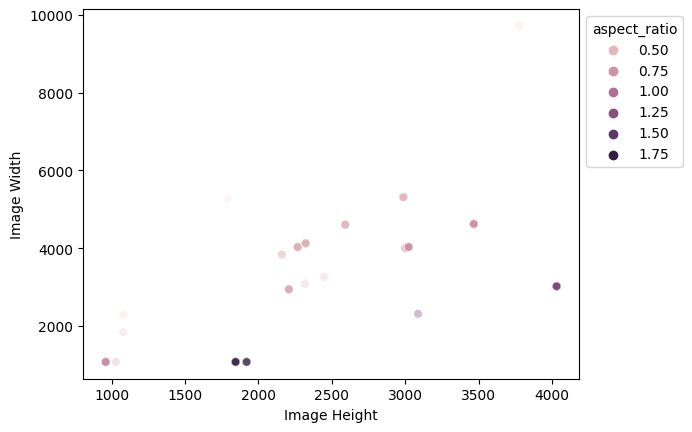

In [162]:
ax = sns.scatterplot(x=umap_meta_df['Image Height'], y=umap_meta_df['Image Width'], hue = umap_meta_df['aspect_ratio'], alpha=0.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

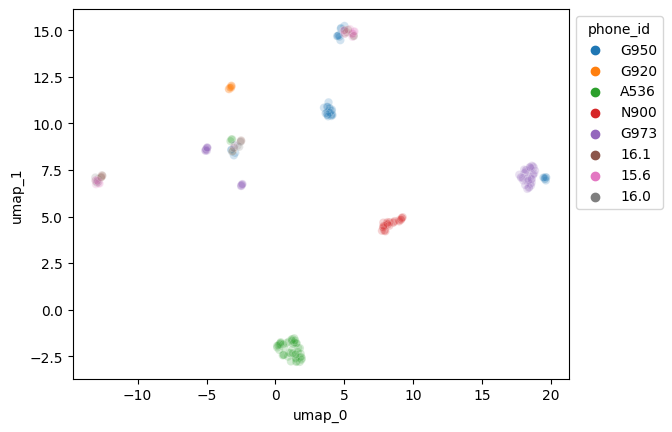

In [150]:
ax = sns.scatterplot(x=umap_meta_df['umap_0'], y=umap_meta_df['umap_1'], hue = umap_meta_df['phone_id'], alpha=0.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

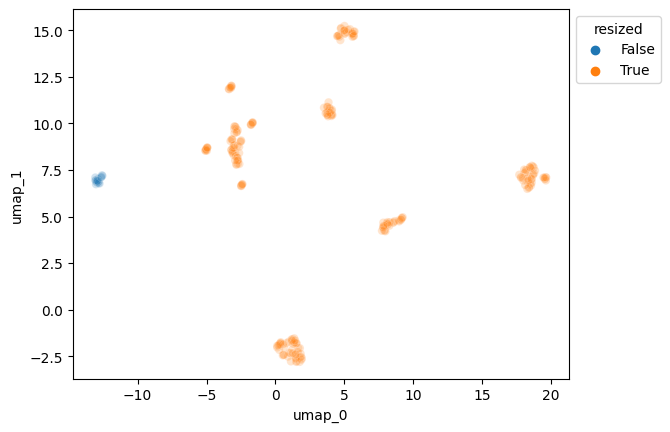

In [156]:
ax = sns.scatterplot(x=umap_meta_df['umap_0'], y=umap_meta_df['umap_1'], hue = umap_meta_df['resized'], alpha=0.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [142]:
ax = sns.scatterplot(data = umap_meta_df, x='umap_0', y='umap_1', hue = 'image_height', alpha=0.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ValueError: Could not interpret value `image_height` for parameter `hue`

| Software | Camera id | Camera Type | 
| --- | --- | --- |
| 15.6.1 | iPhone |
| 16.0.2 | iPhone |
| 16.1.1 | iPhone |
| A536...VF2 | NatNew2 | Galaxy A53 |
| A536...VGA | NatNew | Galaxy A53 |
| G920...PJK | NatOld2 | Galaxy S6 | 
| G950...RB7 | NatOld | Galaxy S8 |
| G973...SH1 | AdamOld | Galaxy S10 |
| G973...SIG | AdamOld, AdamOld2 | Galaxy S10 |
| N900...OK6 | AdamOldOld | Note3 |
| None | iPhone, AdamOldOld2 |

In [55]:
!pwd

/Users/adam/Desktop/Nat_SPNandNoiseprint/noiseprint_main


In [56]:
meta_data = get_image_metadata('../Adam_Old/20191009_103451.jpg')
meta_data

{'Filename': '../Adam_Old/20191009_103451.jpg',
 'Image Size': (4032, 2268),
 'Image Height': 2268,
 'Image Width': 4032,
 'Image Format': 'JPEG',
 'Image Mode': 'RGB',
 'Image is Animated': False,
 'Frames in Image': 1,
 'ImageWidth': 4032,
 'ImageLength': 2268,
 'GPSInfo': 656,
 'ResolutionUnit': 2,
 'ExifOffset': 238,
 'Make': 'samsung',
 'Model': 'SM-G973F',
 'Software': 'G973FXXS3ASH1',
 'Orientation': 1,
 'DateTime': '2019:10:09 10:34:49',
 'YCbCrPositioning': 1,
 'XResolution': 72.0,
 'YResolution': 72.0}

In [57]:
meta_data = get_image_metadata('../Adam_Old_Old/20160329_203932.jpg')
meta_data

{'Filename': '../Adam_Old_Old/20160329_203932.jpg',
 'Image Size': (4128, 2322),
 'Image Height': 2322,
 'Image Width': 4128,
 'Image Format': 'JPEG',
 'Image Mode': 'RGB',
 'Image is Animated': False,
 'Frames in Image': 1,
 'ImageWidth': 4128,
 'ImageLength': 2322,
 'ResolutionUnit': 2,
 'ExifOffset': 226,
 'Make': 'samsung',
 'Model': 'SM-N9005',
 'Software': 'N9005XXUGBOK6',
 'Orientation': 1,
 'DateTime': '2016:03:29 20:39:32',
 'YCbCrPositioning': 1,
 'XResolution': 72.0,
 'YResolution': 72.0}

In [58]:
meta_data = get_image_metadata('../Nat_Old/20180404_082007.jpg')
meta_data

{'Filename': '../Nat_Old/20180404_082007.jpg',
 'Image Size': (4032, 3024),
 'Image Height': 3024,
 'Image Width': 4032,
 'Image Format': 'JPEG',
 'Image Mode': 'RGB',
 'Image is Animated': False,
 'Frames in Image': 1,
 'ResolutionUnit': 2,
 'ExifOffset': 202,
 'Make': 'samsung',
 'Model': 'SM-G950F',
 'Software': 'G950FXXU1CRB7',
 'Orientation': 6,
 'DateTime': '2018:04:04 08:20:06',
 'YCbCrPositioning': 1,
 'XResolution': 72.0,
 'YResolution': 72.0}